In [78]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch import nn
from torch import optim

In [42]:
my_transforms = transforms.Compose([ 
                                  
                                   transforms.ColorJitter(brightness=0.6), 
                                   transforms.RandomRotation(degrees=9), 
                                   transforms.RandomHorizontalFlip(p=0.1), 
                                   transforms.RandomGrayscale(p=0.2), 
                                   transforms.ToTensor()])

In [132]:
train = torchvision.datasets.CIFAR10(root='data/', train=True, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified


In [51]:
image, label = train[1]

In [52]:
# в pytorch картинки скачиваются в другой последовательснти, то есть сначала слои, потом разрешение пикселей
# чтобы картинка отображалась правильно, надо кол-во слоев поставить в конец через permute(1, 2, 0)
print(image.size())
image.permute(1, 2, 0).shape

torch.Size([3, 32, 32])


torch.Size([32, 32, 3])

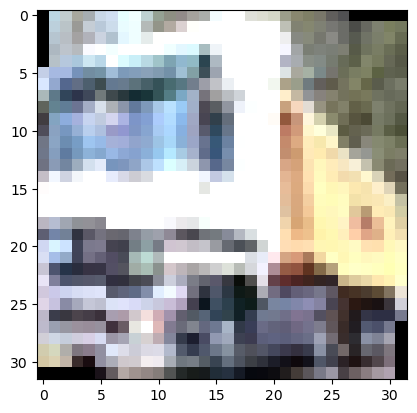

In [53]:
plt.imshow(image.permute(1, 2, 0).numpy())

In [133]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [134]:
# Определяем на чем у нас будут производиться вычисления (cuda/cpu)
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')  
device

device(type='cuda', index=0)

In [135]:
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=8, shuffle=True) 

In [136]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [137]:
image.view(image.shape[0], -1).size()

torch.Size([3, 1024])

In [175]:
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        #первый слой, кол-во входов по кол-ву пикселей в картинкеб кол-во выходов по кол-ву нейонов в следующем слое
        self.fc1 = nn.Linear(input_dim, 4*hidden_dim)
        self.fc2 = nn.Linear(4*hidden_dim, 2*hidden_dim)
        self.fc3 = nn.Linear(2*hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1) # переводим из (32,32,3) в (3,1024)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        return x
    
    def predict(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        #x = F.softmax(x)
        return x
    
model1 = Model(3072, 100, 10)
model1.train()
        

Model(
  (fc1): Linear(in_features=3072, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [176]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.01)

In [ ]:
import time

In [168]:
model1.to(device)

Model(
  (fc1): Linear(in_features=3072, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [169]:
%%time

num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    running_items = 0.0
    
    for i, data in enumerate(train_loader):
        inputs = data[0].to(device)
        labels = data[1].to(device)
        
        # обнуляем граденты
        optimizer.zero_grad()
        #make preds
        outputs = model1(inputs)
        # loss 
        loss = criterion(outputs, labels)
        # backward, using loss
        loss.backward()
        #adjust weights
        optimizer.step()
        
        #stats
        running_loss += loss.item()
        running_items += len(labels)
        
        if i % 300 ==0:
            print(f'Epoch [{epoch+1}/{num_epochs}]. ' \
                 f'Step [{i+1}/{len(train_loader)}]. '\
                 f'Loss {running_loss/running_items:.3f}')
            running_loss, running_items = 0.0, 0.0

Epoch [1/5]. Step [1/98]. Loss 0.004
Epoch [2/5]. Step [1/98]. Loss 0.005
Epoch [3/5]. Step [1/98]. Loss 0.004
Epoch [4/5]. Step [1/98]. Loss 0.004
Epoch [5/5]. Step [1/98]. Loss 0.004
Wall time: 34.7 s


In [143]:
#cpu 40.6s
# gpu 33.8s
data_iter = iter(test_loader)
images, labels = next(data_iter)

In [164]:
import numpy as np
model1.to(device)

Model(
  (fc1): Linear(in_features=3072, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [170]:
#без softmax
acc = 0
batches = 0

for x_batch, y_batch in test_loader:
  # загружаем батч данных (вытянутый в линию)
  batches += 1
  x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
  y_batch = y_batch.to(device)

  preds = torch.argmax(model1(x_batch), dim=1)
  acc += (preds==y_batch).cpu().numpy().mean()

print(f'Test accuracy {acc / batches:.3}')

Test accuracy 0.184


In [207]:
# вместе с softmax
data_iter = iter(test_loader)
images, labels = next(data_iter)

gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['truck' 'frog' 'bird' 'frog' 'plane' 'car' 'frog' 'car']
['ship' 'dog' 'cat' 'frog' 'dog' 'frog' 'car' 'horse']
Accuracy is 0.125


In [180]:
pip install torch-summary >> None

Note: you may need to restart the kernel to use updated packages.


In [181]:
# перепишем и увеличим модель в более простом стиле
from torchsummary import summary


In [197]:
model2 = nn.Sequential(nn.Linear(3072, 1536),
                      nn.LeakyReLU(), 
                      nn.Linear(1536, 512), 
                      nn.LeakyReLU(), 
                      nn.Linear(512, 256), 
                      nn.LeakyReLU(), 
                      nn.Linear(256, 64), 
                      nn.LeakyReLU(), 
                      nn.Linear(64, 10))

In [198]:
summary(model2)

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            4,720,128
├─LeakyReLU: 1-2                         --
├─Linear: 1-3                            786,944
├─LeakyReLU: 1-4                         --
├─Linear: 1-5                            131,328
├─LeakyReLU: 1-6                         --
├─Linear: 1-7                            16,448
├─LeakyReLU: 1-8                         --
├─Linear: 1-9                            650
Total params: 5,655,498
Trainable params: 5,655,498
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            4,720,128
├─LeakyReLU: 1-2                         --
├─Linear: 1-3                            786,944
├─LeakyReLU: 1-4                         --
├─Linear: 1-5                            131,328
├─LeakyReLU: 1-6                         --
├─Linear: 1-7                            16,448
├─LeakyReLU: 1-8                         --
├─Linear: 1-9                            650
Total params: 5,655,498
Trainable params: 5,655,498
Non-trainable params: 0

In [199]:
model2.to(device)

Sequential(
  (0): Linear(in_features=3072, out_features=1536, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=1536, out_features=512, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=256, out_features=64, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=64, out_features=10, bias=True)
)

In [200]:
criterion = nn.CrossEntropyLoss()      # (logsoftmax + negative likelihood) в своей основе применительно к логитам (logits)

optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3, betas=(0.9, 0.99))

In [201]:
epochs = 15
history = []

In [202]:
for i in range(epochs):
  for x_batch, y_batch in train_loader:
    # 1. # загружаем батч данных (вытянутый в линию)
    x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
    y_batch = y_batch.to(device)

    # 2. вычисляем скор с помощью прямого распространения ( .forward or .__call__ )
    logits = model2(x_batch)

    # 3. вычислеяем - функцию потерь (loss)
    loss = criterion(logits, y_batch)
    history.append(loss.item())

    # 4. вычисляем градиенты
    optimizer.zero_grad()
    loss.backward()

    # 5. шаг градиентного спуска
    optimizer.step()

  print(f'{i+1},\t loss: {history[-1]}')

1,	 loss: 1.8687931299209595
2,	 loss: 1.6951501369476318
3,	 loss: 1.67483389377594
4,	 loss: 1.556384801864624
5,	 loss: 1.49784255027771
6,	 loss: 1.3933063745498657
7,	 loss: 1.3575996160507202
8,	 loss: 1.3342665433883667
9,	 loss: 1.3700010776519775
10,	 loss: 1.4231122732162476
11,	 loss: 1.262865662574768
12,	 loss: 1.1881165504455566
13,	 loss: 1.320119023323059
14,	 loss: 1.1759328842163086
15,	 loss: 1.1721328496932983


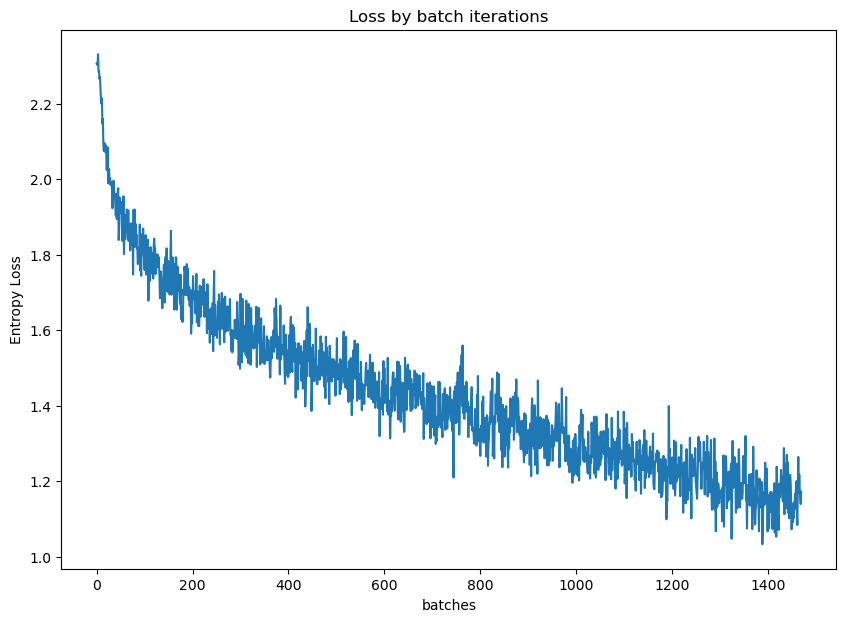

In [203]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))

plt.plot(history)

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')

plt.show()

In [220]:
from sklearn.metrics import accuracy_score
acc = 0
batches = 0

for x_batch, y_batch in test_loader:
  # загружаем батч данных (вытянутый в линию)
  batches += 1
  x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
  y_batch = y_batch.to(device)

  preds = torch.argmax(model2(x_batch), dim=1)
  acc += (preds==y_batch).cpu().numpy().mean()

print(f'Test accuracy {acc / batches:.3}')

Test accuracy 0.534


In [221]:
model2.to('cpu')

Sequential(
  (0): Linear(in_features=3072, out_features=1536, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=1536, out_features=512, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=256, out_features=64, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=64, out_features=10, bias=True)
)

In [215]:
data_iter = iter(test_loader)
images, labels = next(data_iter)

In [223]:


model2.eval()
preds = torch.argmax(model2(images.view(images.shape[0], -1)), dim=1)
# outputs = model2(images)
# _, predicted = torch.max(outputs, 1)



gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[preds[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['car' 'bird' 'frog' 'bird' 'plane' 'bird' 'plane' 'ship']
['truck' 'cat' 'frog' 'bird' 'horse' 'cat' 'plane' 'ship']
Accuracy is 0.5
